# Elliptic particle in box

In [1]:
from pydmc import *
%matplotlib inline

In [36]:
nconf = 100
time_step = .25e-1

blocks = 200
steps_per_block = 40
neq = 10

q0 = 0.8253525490491695 
a0 = 1
exact = 2*q0/a0**2

reference_energy = 1.71587 / a0**2

da = 1e-5
hamiltonian = lambda psi, x: -0.5 * psi.laplacian(x)

In [37]:
class ParabolicWaveFunction:

    def __init__(self, a):
        self._a = a
        self._alpha = self._a*math.cosh(1)
        self._beta = self._a*math.sinh(1)
        self._ellipse_pars = np.array([self._alpha, self._beta])

    def __call__(self, x):
        r = np.sum((x / self._ellipse_pars)**2)
        if r > 1:
            return 0
        return 1 - r

    def gradient(self, xx):
        return -2 * xx / self._ellipse_pars**2
    
    def laplacian(self, xx):
        return -2 * (1/self._ellipse_pars**2).sum()

    def geometry_parameters(self):
        return self._a

    def deform(self, parameter_change):
        return ParabolicWaveFunction(self._a + parameter_change)

    def geometry_gradient(self, x):
        x, y = x
        return 2*(x**2/self._alpha**3*math.cosh(1) \
                        + y**2/self._beta**3*math.sinh(1))

In [38]:
np.random.seed(0)
confs = [np.random.uniform(low=-0.5, high=0.5, size=2) for _ in range(nconf)]
walkers = [Walker(conf, 1.0) for conf in confs]

In [39]:
brancher = SRBrancher()
#brancher = SplitJoinBrancher()

ar = DiffuseAcceptRejectDMC(fixed_node=True)
guiding_wf = ParabolicWaveFunction(a0)

dmc = DMC(hamiltonian, walkers, brancher, ar, guiding_wf, reference_energy)

dmc.run_dmc(time_step, blocks, steps_per_block, neq=neq, progress=True)

100%|██████████| 200/200 [02:07&lt;00:00,  1.57it/s]


In [40]:
energy = dmc.energy_estimate[-1]
err = dmc.energy_error[-1]
print(f"Energy: {energy:.5f} +/- {err:.5f}")
print(f"Exact:  {exact:.5f}")

Energy: 1.64988 +/- 0.01062
Exact:  1.65071


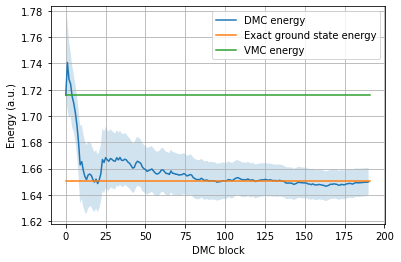

In [41]:
plt.figure()
ns = np.arange(0, len(dmc.energy_estimate))
plt.plot(ns, dmc.energy_estimate, label="DMC energy")
plt.fill_between(ns, dmc.energy_estimate - dmc.energy_error, dmc.energy_estimate + dmc.energy_error, alpha=0.2)

plt.plot([0, len(dmc.energy_estimate)], [exact, exact], label="Exact ground state energy")
plt.plot([0, len(dmc.energy_estimate)], [reference_energy, reference_energy], label="VMC energy")
plt.legend()
plt.xlabel("DMC block")
plt.ylabel("Energy (a.u.)")
plt.grid()